In [1]:
import torch
import json
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import ml_collections
import numpy as np

from data import MNISTSet
from torch.utils.data import DataLoader
from model import SetFlowModule
from config import create_config
from flow_matching.path.scheduler import CondOTScheduler, CosineScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver

In [26]:
ckpt_path = "weights/mnist-20250507-024355/checkpoint-epoch=24-train_loss=0.183433.ckpt"

with open(os.path.join(
        os.path.join(os.path.join(*ckpt_path.split("/")[:2])), "config.json"), 
        "r"
    ) as f:
        config_dict = json.load(f)
config = ml_collections.ConfigDict(config_dict)

mf_vfm_model = SetFlowModule.load_from_checkpoint(
    config=config,
    strict=False,
    checkpoint_path=ckpt_path
).to("cuda:3")

In [3]:
dataset = MNISTSet()

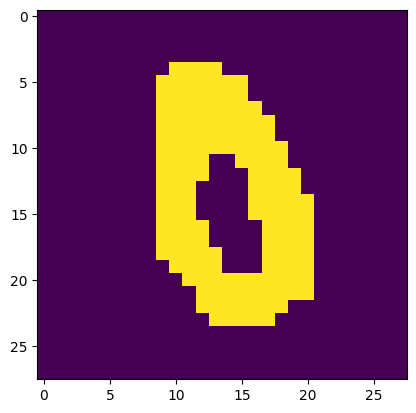

In [73]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
_, sample, mask = next(iter(dataloader))
x, y = sample.unbind(dim=-1)
x = (x[mask.bool()].squeeze(0) * 27).cpu().numpy()
y = (y[mask.bool()].squeeze(0) * 27).cpu().numpy()

image = np.zeros((28, 28), dtype=np.float32)
for x, y in zip(x, y):
    if 0 <= y < 27 and 0 <= x < 27:
        image[int(x), int(y)] = 1.0
        
plt.imshow(image)

In [110]:
# ckpt_path = "weights/mnist-20250507-024355/checkpoint-epoch=24-train_loss=0.183433.ckpt"
ckpt_path = "weights/mnist-20250507-025043/checkpoint-epoch=24-train_loss=0.047234.ckpt"

with open(os.path.join(
        os.path.join(os.path.join(*ckpt_path.split("/")[:2])), "config.json"), 
        "r"
    ) as f:
        config_dict = json.load(f)
config = ml_collections.ConfigDict(config_dict)

mf_vfm_model = SetFlowModule.load_from_checkpoint(
    config=config,
    strict=False,
    checkpoint_path=ckpt_path
).to("cuda:3")

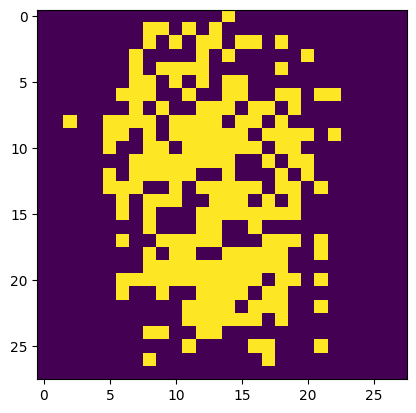

In [76]:
# out = mf_vfm_model.reconstruct(sample.to("cuda:3"), 342, timesteps=200, attn_mask=mask.to("cuda:3"), mode="vfm")
out = mf_vfm_model.reconstruct(sample.to("cuda:3"), 342, timesteps=200, attn_mask=mask.to("cuda:3"), mode="cfm")
coords = out[0].detach().cpu().numpy()
coords *= 27

image = np.zeros((28, 28), dtype=np.float32)
for (y, x) in coords.astype(int):
    if 0 <= y < 27 and 0 <= x < 27:
        image[y, x] = 1.0
        
plt.imshow(image)

In [77]:
import numpy as np
from scipy.spatial import cKDTree, distance_matrix
from scipy.optimize import linear_sum_assignment

# ---------- low-level distances ------------------------------------------------
def chamfer_distance(P: np.ndarray, Q: np.ndarray) -> float:
    """
    Symmetric Chamfer distance (squared ℓ2) between two N×3 point clouds.
    """
    # P,Q shape: [N,3]
    tree_P, tree_Q = cKDTree(P), cKDTree(Q)
    dPQ, _ = tree_P.query(Q)            # for every q ∈ Q find nearest p ∈ P
    dQP, _ = tree_Q.query(P)            # vice-versa
    return (dPQ**2).mean() + (dQP**2).mean()


def emd_distance(P: np.ndarray, Q: np.ndarray) -> float:
    """
    Exact Earth-Mover’s distance (Wasserstein-1) via the Hungarian algorithm.
    Assumes |P| == |Q|; time O(N³).  Use Sinkhorn or PyTorch-EMD for 1k+ points.
    """
    M = distance_matrix(P, Q)           # pairwise ℓ2
    row_idx, col_idx = linear_sum_assignment(M)
    return M[row_idx, col_idx].mean()

# ---------- data-set level helpers --------------------------------------------
def _pairwise_distances(A, B, metric):
    """Return |A|×|B| matrix with metric(ai, bj)."""
    out = np.empty((len(A), len(B)))
    for i, a in enumerate(A):
        for j, b in enumerate(B):
            out[i, j] = metric(a, b)
    return out


def mmd(gen_set, ref_set, metric):
    """
    Minimum-Matching Distance (MMD).  “Fidelity” – lower is better.
    Measures: for every reference shape y ∈ ref find min_x∈gen d(x,y) and average.
    """
    D = _pairwise_distances(ref_set, gen_set, metric)
    return D.min(axis=1).mean()


def coverage(gen_set, ref_set, metric):
    """
    Coverage (COV).  “Diversity” – higher is better.
    Fraction of reference shapes that are the nearest neighbour of some gen shape.
    """
    D = _pairwise_distances(gen_set, ref_set, metric)
    nn = D.argmin(axis=1)               # nearest ref for each generated
    covered = np.unique(nn).size
    return 100.0 * covered / len(ref_set)


def one_nna(gen_set, ref_set, metric):
    """
    1-Nearest-Neighbour Accuracy (1-NNA).  “Two-sample test” – *lower* is better.
    50 % ≈ indistinguishable, 100 % = perfect separation.
    """
    all_set = gen_set + ref_set
    labels   = np.array([0]*len(gen_set) + [1]*len(ref_set))
    D = _pairwise_distances(all_set, all_set, metric)
    np.fill_diagonal(D, np.inf)         # ignore self-distance
    nn = D.argmin(axis=1)
    same = (labels == labels[nn]).mean()
    return 100.0 * same

def sample_cloud(cloud: np.ndarray, k: int = 1024, rng=None) -> np.ndarray:
    """
    Return `k` distinct points chosen uniformly at random from `cloud` (N×3).
    If N < k we sample with replacement, otherwise without.
    """
    rng = np.random.default_rng() if rng is None else rng
    N = cloud.shape[0]
    replace = N < k
    idx = rng.choice(N, size=k, replace=replace)
    return cloud[idx]

In [78]:
test_data = []
for _ in range(50):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    _, sample, mask = next(iter(dataloader))
    x, y = sample.unbind(dim=-1)
    x = (x[mask.bool()].squeeze(0) * 27).cpu().numpy()
    y = (y[mask.bool()].squeeze(0) * 27).cpu().numpy()
    test_data.append((sample, mask))

In [111]:
from tqdm import tqdm
gen_data = []
for sample, mask in tqdm(test_data):
    out = mf_vfm_model.reconstruct(sample.to("cuda:3"), 342, timesteps=200, attn_mask=mask.to("cuda:3"), mode="cfm")
    coords = out[0].detach().cpu().numpy()
    # print(coords[mask[0]].shape)
    gen_data.append(coords[mask[0]])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:09<00:00,  2.58s/it]


In [112]:
# gen_1k = np.array(gen_data)
ref_1k = [s[m].cpu().numpy() for s, m in test_data]

In [113]:
mmd_cd  = mmd(gen_data, ref_1k, chamfer_distance) * 1e3
# mmd_emd = mmd(gen_1k, ref_1k, emd_distance)    * 1e2
cov_cd  = coverage(gen_data, ref_1k, chamfer_distance)
# cov_emd = coverage(gen_1k, ref_1k, emd_distance)
nna_cd  = one_nna(gen_data, ref_1k, chamfer_distance)
# nna_emd = one_nna(gen_1k, ref_1k, emd_distance)

In [115]:
print("cfm mmd_cd: ", mmd_cd)
print("cfm cov_cd: ", cov_cd)
print("cfm nna_cd: ", nna_cd)

cfm mmd_cd:  3.5135862215540468
cfm cov_cd:  30.0
cfm nna_cd:  92.0
